<a href="https://colab.research.google.com/github/aayushrai/Tensorfow/blob/master/U_net(segmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 120kB/s 
     |████████████████████████████████| 3.8MB 30.9MB/s 
     |████████████████████████████████| 450kB 39.5MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [0]:
dataset,info  = tfds.load("oxford_iiit_pet:3.0.0",with_info=True)

In [0]:
def normalize(input_image,input_mask):
    input_image = tf.cast(input_image,tf.float32)/ 255.0
    input_mask -= 1
    return input_image,input_mask


In [0]:
def load_image_train(datapoint):
   input_image = tf.image.resize(datapoint["image"],(128,128))
   input_mask = tf.image.resize(datapoint["segmentation_mask"],(128,128))
   if tf.random.uniform(()) > .5:
     input_image = tf.image.flip_left_right(input_image)
     input_mask = tf.image.flip_left_right(input_mask)
   input_image,input_mask = normalize(input_image,input_mask)
   return input_image ,input_mask

In [0]:
def load_image_test(datapoint):
   input_image = tf.image.resize(datapoint["image"],(128,128))
   input_mask = tf.image.resize(datapoint["segmentation_mask"],(128,128))
   input_image,input_mask = normalize(input_image,input_mask)
   return input_image ,input_mask

In [0]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.0.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.
',
    urls=['http://www.robots.ox.ac.uk/~vgg/data/pets/'],
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Jawahar, C.~V.",
      title        = "Cats and Dogs",
      booktitle    =

In [0]:
Train_length = info.splits["train"].num_examples
Batch_size = 64
Buffer_size = 1000
Steps_per_epoch = Train_length//Batch_size
OUTPUT_CHANNELS = 3

In [0]:
train = dataset["train"].map(load_image_train,num_parallel_calls = tf.data.experimental.AUTOTUNE )
test = dataset["test"].map(load_image_test)

In [0]:
train_dataset = train.cache().shuffle(Buffer_size).batch(Batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(Batch_size)

In [0]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ["input_image","true_mask","predicted_mask"]
    
    for i in range(len(display_list)):
      plt.subplot(1,len(display_list),i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
      plt.axis("off")
    plt.show()

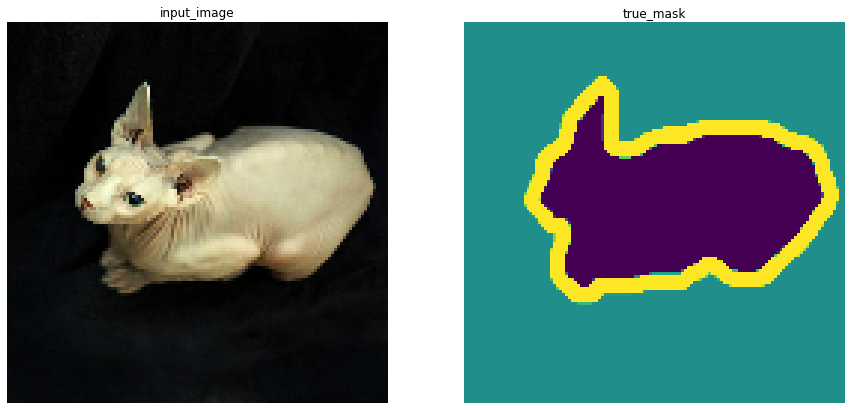

In [0]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

#feature exctraction
down_stack = tf.keras.Model(inputs=base_model.input,outputs=layers)
down_stack.trainble =False

In [0]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

In [0]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
  
  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [0]:
up_stack = [
     upsample(512, 3),  # 4x4 -> 8x8
     upsample(256, 3),  # 8x8 -> 16x16
     upsample(128, 3),  # 16x16 -> 32x32
     upsample(64, 3),   # 32x32 -> 64x64
]

In [0]:
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]1

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

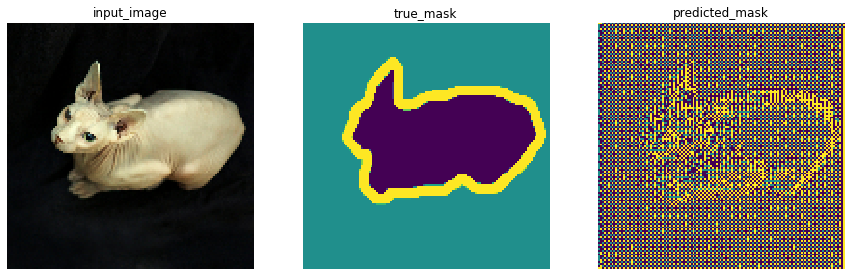

In [0]:
show_predictions()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

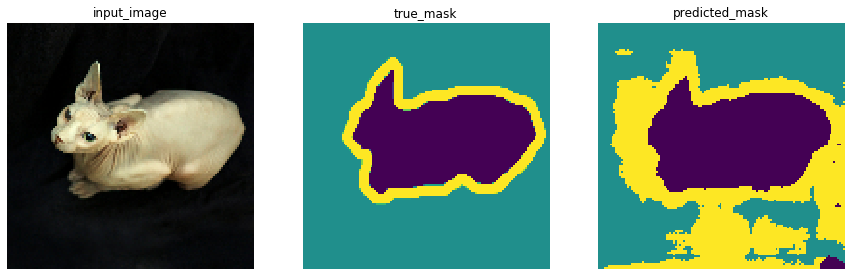


Sample Prediction after epoch 10

57/57 [==============================] - 674s 12s/step - loss: 0.1622 - accuracy: 0.9273 - val_loss: 1.2714 - val_accuracy: 0.5311


In [0]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//Batch_size//VAL_SUBSPLITS
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=Steps_per_epoch,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

In [0]:
 model_histroy.save("animal_segmention.h5")